# Import


In [ ]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib import pyplot
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.datasets import fashion_mnist

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

from typing import List
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import random
import matplotlib.pyplot as plt


In [ ]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target']
x.shape

(150, 2)

# Task 1

## import and preprocess of data

In [ ]:
(train_images_ori, train_labels), (test_images_ori, test_labels) = fashion_mnist.load_data()
CLASS_DESC = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = 10

#normalize the training data
train_images = (train_images_ori / 255) - 0.5
test_images = (test_images_ori / 255) - 0.5

# print(train_images[0])
# print(test_images.shape)

#flatten
train_images = np.reshape(train_images, (60000,784))
test_images = np.reshape(test_images, (10000,784))
#print(train_images[0])
train_images_ori = np.reshape(train_images_ori, (60000,784))
test_images_ori = np.reshape(test_images_ori, (10000,784))

type(train_labels)
#class distribution




4422102/4422102 [==============================] - 0s 0us/step


numpy.ndarray

<BarContainer object of 10 artists>

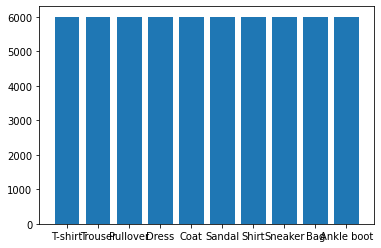

In [ ]:
la,coun = np.unique(train_labels,return_counts=True)

plt.bar(CLASS_DESC,coun)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

# task 2

##MLP class

In [ ]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None

    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size,is_l2=False):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.is_l2 = is_l2

        #self.w = np.ones((output_size, input_size))
        self.w = np.random.normal(0 , 0.0825, size = (output_size, input_size))
        self.b = np.random.normal(0, 0.0825 , size = output_size )
        #self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        #print((self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b)
        #print("Linear",(self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b)
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        if self.is_l2:
          dw = dw + self.w*0.1
        #print(gradient)
        db = gradient
        self.gradient = [dw, db]
        # print("backward")
        #print(gradient.dot(self.w))
        return gradient.dot(self.w)


class TanhLayer(NeuralNetLayer):
    def __init__(self):
      super().__init__()

    def forward(self, x):
      self.gradient = 1-(np.tanh(x))**2 # sech^2{x}
      return np.tanh(x)

    def backward(self, gradient):
      assert self.gradient is not None, "Must call forward before backward"

      return gradient * self.gradient


class LeakyReLULayer(NeuralNetLayer):
  def __init__(self):
        super().__init__()

  def forward(self, x):
      self.gradient = np.where(x > 0, 1.0, 0.01)
      return np.where(x>0, x, 0.01*x)

  def backward(self, gradient):
      assert self.gradient is not None, "Must call forward before backward"

      return gradient * self.gradient

class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        #feature=(x-x.max())/(x.max()-x.min())
        exps = np.exp(x)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        #print("Softmax",exps)
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

def activation_func(f):
        if f == "Relu":
          return ReLULayer()
        if f == "Tanh":
          return TanhLayer()
        if f == "Leaky":
          return LeakyReLULayer()


class MLP:
    def __init__(self,f,nlayer,layer_unit,lr,add_l2 = False):
        self.layers = []
        self.add_l2 = add_l2
        self.lr = lr
        if nlayer != 0:
          self.layers.append(LinearLayer(784, layer_unit[0],add_l2))
          self.layers.append(activation_func(f))
          for i in range(0,nlayer-1):
            self.layers.append(LinearLayer(layer_unit[i], layer_unit[i+1],add_l2))
            self.layers.append(activation_func(f))
          self.layers.append(LinearLayer(layer_unit[-1], 10 ,add_l2))
          self.layers.append(SoftmaxOutputLayer())
        else:
          self.layers.append(LinearLayer(784, 10 ,add_l2))
          self.layers.append(SoftmaxOutputLayer())
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def fit(self, data_x, data_y, steps):
      # train(self, optimizer, data_x, data_y, steps)
      losses = []
      labels = np.eye(10)[np.array(data_y)]
      x = np.split(data_x, 200)
      # print(x)
      y = np.split(labels, 200)
      # print(y)
      n = 0
      opt1 = GradientDescentOptimizer(self, self.lr)
      for _ in tqdm(range(steps)):
        predictions = self.forward(x[n])
        # print(predictions)
        loss = -(y[n] * np.log(predictions)).sum(axis=-1).mean()
        losses.append(loss)
        self.backward(y[n])
        opt1.step()
        n=n+1
        if n == 200:
          n = 0

      plt.plot(losses)
      plt.xlabel("Epoch")
      plt.ylabel("Cross entropy loss")
      plt.show()

    def predict(self,data_x):
          predictions = self.forward(data_x)
          return np.argmax(predictions, axis = 1)

class Optimizer:
    def __init__(self, net: MLP):
        self.net = net
        self.w = 0

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.w = layer.w
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)




## run train


In [ ]:
HIDDEN_SIZE = 128
GRADIENT_STEPS = 3000

100%|██████████| 3000/3000 [00:57<00:00, 51.89it/s]


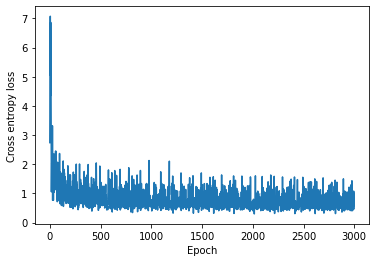

0.8299


100%|██████████| 3000/3000 [10:39<00:00,  4.69it/s]


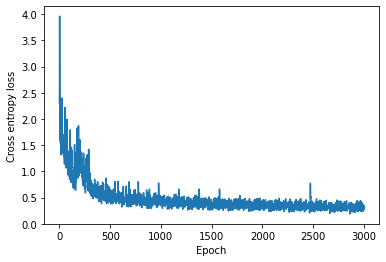

0.8657


100%|██████████| 3000/3000 [12:55<00:00,  3.87it/s]


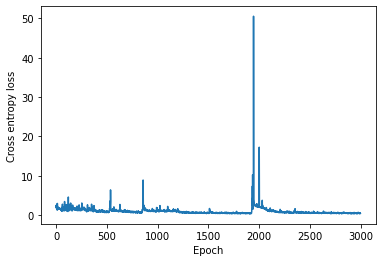

0.7985


In [ ]:
mlp = MLP("Relu",0,[],1)
mlp1 = MLP("Relu",1,[HIDDEN_SIZE],1)
mlp2 = MLP("Relu",2,[HIDDEN_SIZE,HIDDEN_SIZE],1)


mlp.fit(train_images, train_labels, GRADIENT_STEPS)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))


mlp1.fit(train_images, train_labels, GRADIENT_STEPS)
print(sum(mlp1.predict(test_images)== test_labels)/len(test_labels))


mlp2.fit(train_images, train_labels, GRADIENT_STEPS)
print(sum(mlp2.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 3000/3000 [10:54<00:00,  4.59it/s]


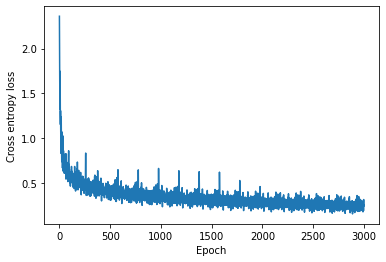

0.878


In [ ]:
mlp2 = MLP("Relu",2,[HIDDEN_SIZE,HIDDEN_SIZE],3e-1)

mlp2.fit(train_images, train_labels, GRADIENT_STEPS)
print(sum(mlp2.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 3000/3000 [11:27<00:00,  4.36it/s]


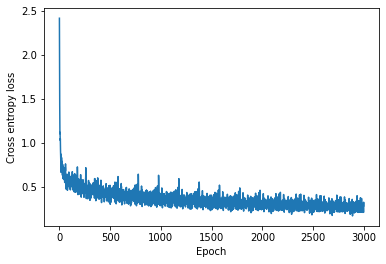

0.8755


In [ ]:
mlp_tanh = MLP("Tanh",2,[HIDDEN_SIZE,HIDDEN_SIZE],3e-1)
mlp_tanh.fit(train_images, train_labels, GRADIENT_STEPS)
print(sum(mlp_tanh.predict(test_images)== test_labels)/len(test_labels))


100%|██████████| 3000/3000 [11:11<00:00,  4.47it/s]


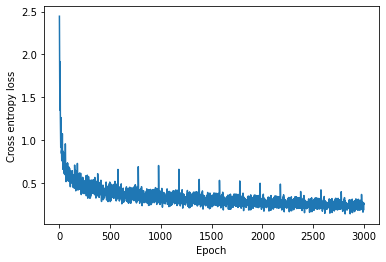

0.8804


In [ ]:
mlp_leaky = MLP("Leaky",2,[HIDDEN_SIZE,HIDDEN_SIZE],3e-1)
mlp_leaky.fit(train_images, train_labels, GRADIENT_STEPS)
print(sum(mlp_leaky.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 500/500 [02:17<00:00,  3.64it/s]


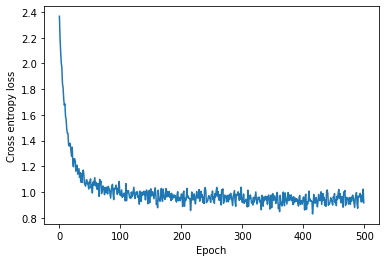

0.7168


In [ ]:
#lambda = 0.1

mlp_l2 = MLP("Relu",2,[HIDDEN_SIZE,HIDDEN_SIZE],1e-1,True)
mlp_l2.fit(train_images, train_labels, 500)
print(sum(mlp_l2.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


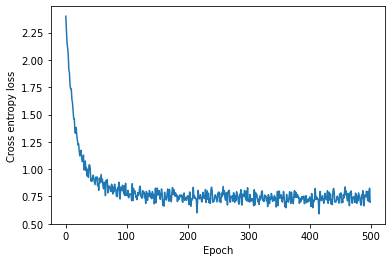

0.7574


In [ ]:
#lambda = 0.05

mlp_l2 = MLP("Relu",2,[HIDDEN_SIZE,HIDDEN_SIZE],1e-1,True)
mlp_l2.fit(train_images, train_labels, 500)
print(sum(mlp_l2.predict(test_images)== test_labels)/len(test_labels))


100%|██████████| 500/500 [02:15<00:00,  3.68it/s]


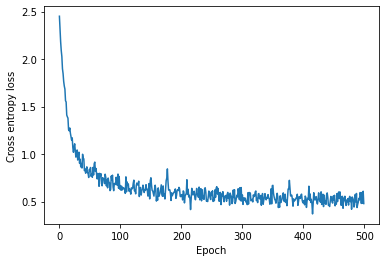

0.8106


In [ ]:
#lambda = 0.01
mlp_l2 = MLP("Relu",2,[HIDDEN_SIZE,HIDDEN_SIZE],1e-1,True)
mlp_l2.fit(train_images, train_labels, 500)
print(sum(mlp_l2.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 400/400 [01:38<00:00,  4.08it/s]


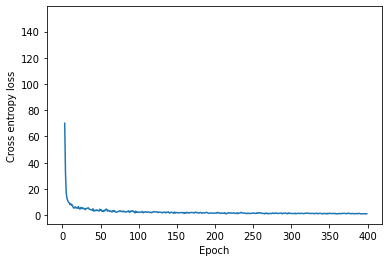

0.7206


In [ ]:
#lr = 1e-3
mlp_ori = MLP("Relu",2,[HIDDEN_SIZE,HIDDEN_SIZE],1e-3)
mlp_ori.fit(train_images_ori, train_labels, GRADIENT_STEPS)
print(sum(mlp_ori.predict(test_images_ori)== test_labels)/len(test_images_ori))


100%|██████████| 400/400 [03:22<00:00,  1.97it/s]


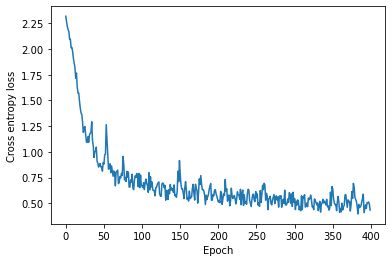

0.8215


In [ ]:
mlp = MLP("Relu",3,[300,100,50],1e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 400)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 400/400 [03:23<00:00,  1.97it/s]


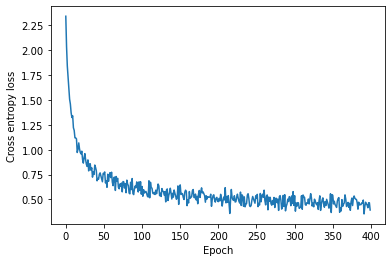

0.8283


In [ ]:
mlp = MLP("Tanh",2,[300,100],1e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 400)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 400/400 [03:44<00:00,  1.78it/s]


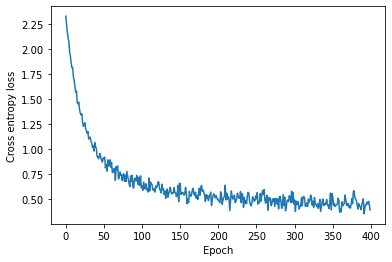

0.8336


In [ ]:
mlp = MLP("Tanh",4,[400,300,100,50],1e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 400)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 400/400 [04:10<00:00,  1.60it/s]


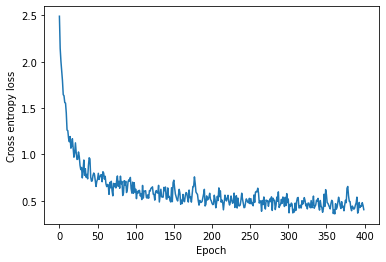

0.834


In [ ]:
mlp = MLP("Relu",3,[300,200,100],1e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 400)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 3000/3000 [18:48<00:00,  2.66it/s]


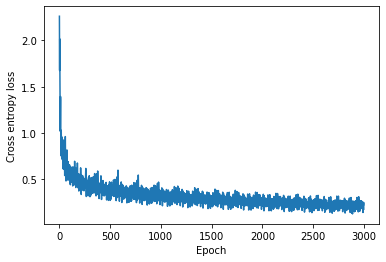

0.885


In [ ]:
mlp = MLP("Relu",2,[300,100],3e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 3000)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 600/600 [06:39<00:00,  1.50it/s]


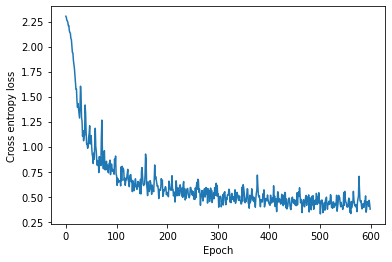

0.8394


In [ ]:
mlp = MLP("Relu",4,[300,200,100,50],1e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 600)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 600/600 [03:38<00:00,  2.75it/s]


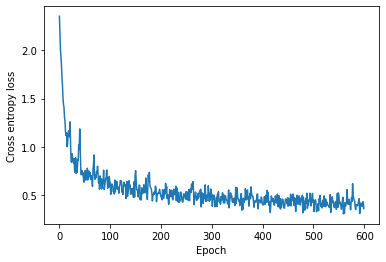

0.8429


In [ ]:
mlp = MLP("Relu",3,[300,200,100],1e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 600)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 800/800 [07:39<00:00,  1.74it/s]


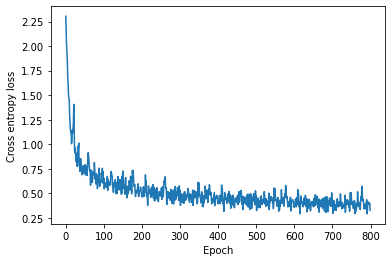

0.8495


In [ ]:
mlp = MLP("Relu",3,[300,200,100],1e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 800)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 800/800 [08:24<00:00,  1.59it/s]


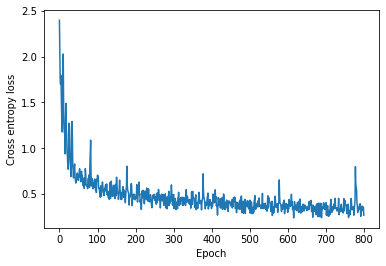

0.8641


In [ ]:
mlp = MLP("Relu",3,[300,200,100],3e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 800)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 1000/1000 [10:26<00:00,  1.60it/s]


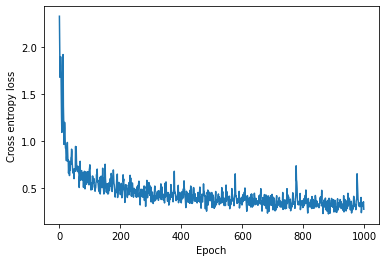

0.8669


In [ ]:
mlp = MLP("Relu",3,[300,200,100],3e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 1000)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 3000/3000 [23:50<00:00,  2.10it/s]


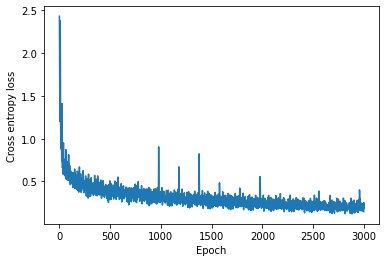

0.8849


In [ ]:
mlp = MLP("Relu",3,[300,200,100],3e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 3000)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 3000/3000 [24:52<00:00,  2.01it/s]


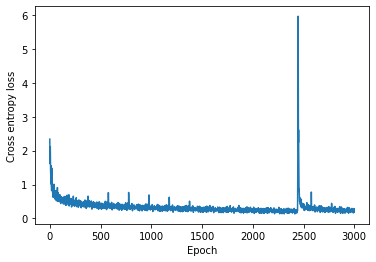

0.8783


In [ ]:
mlp = MLP("Leaky",3,[300,200,100],3e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 3000)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

100%|██████████| 1200/1200 [18:59<00:00,  1.05it/s]


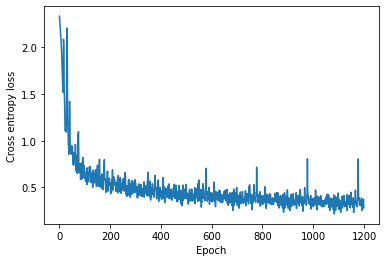

0.8616


In [ ]:
mlp = MLP("Relu",5,[400,300,200,100,50],1e-1)  # changed learning rate to 0.1
mlp.fit(train_images, train_labels, 1200)
print(sum(mlp.predict(test_images)== test_labels)/len(test_labels))

### Creativity


100%|██████████| 200/200 [00:51<00:00,  3.90it/s]


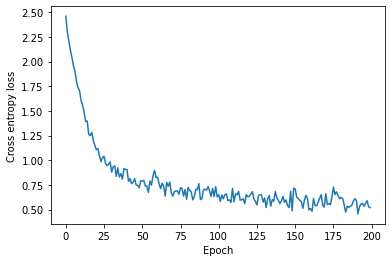

100%|██████████| 200/200 [00:54<00:00,  3.66it/s]


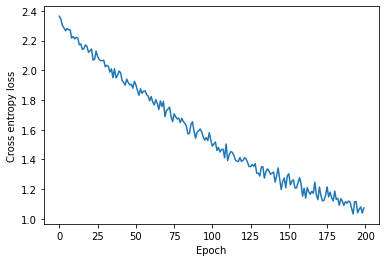

100%|██████████| 200/200 [00:48<00:00,  4.14it/s]


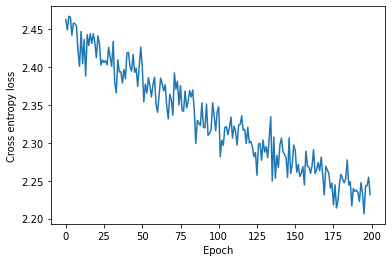

100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


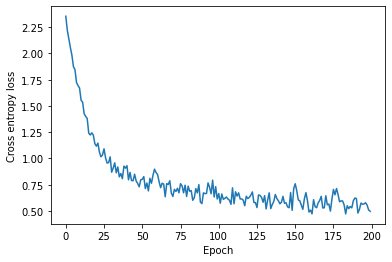

100%|██████████| 200/200 [00:53<00:00,  3.76it/s]


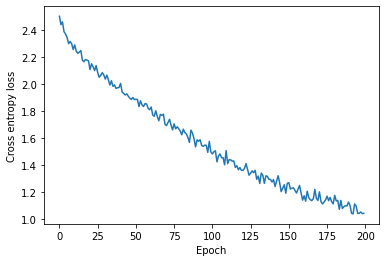

100%|██████████| 200/200 [00:55<00:00,  3.61it/s]


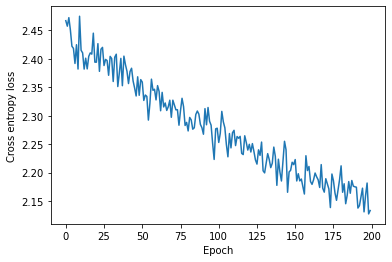

100%|██████████| 400/400 [03:17<00:00,  2.02it/s]


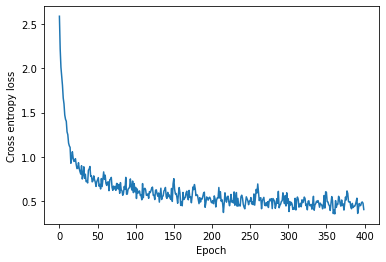

100%|██████████| 400/400 [03:10<00:00,  2.10it/s]


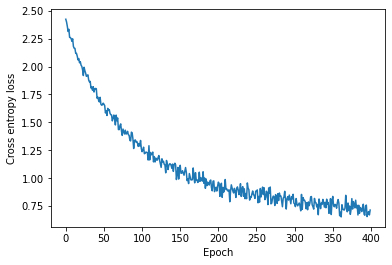

100%|██████████| 400/400 [03:28<00:00,  1.92it/s]


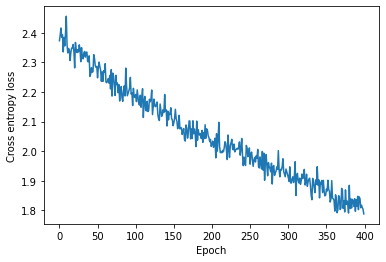

<function matplotlib.pyplot.show(*args, **kw)>

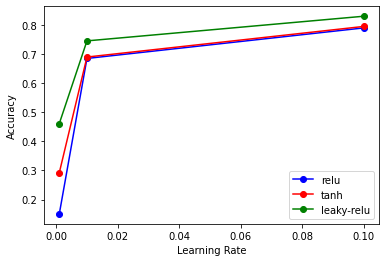

In [ ]:
HIDDEN_SIZE = 128
GRADIENT_STEPS = 200
learn_rate = [1e-1,1e-2,1e-3]
model_acc = []
models = ['Relu','Leaky']
for m in models:
  acc = []
  for lrate in learn_rate:
    model = MLP(m,2,[HIDDEN_SIZE,HIDDEN_SIZE],lrate)
    model.fit(train_images, train_labels, GRADIENT_STEPS)
    acc.append(sum(model.predict(test_images)== test_labels)/len(test_labels))
  model_acc.append(acc)

acc= []
for lrate in learn_rate:
  model = MLP("Relu",2,[300,100],lrate)  # changed learning rate to 0.1
  model.fit(train_images, train_labels, 400)
  acc.append(sum(model.predict(test_images)== test_labels)/len(test_labels))
model_acc.append(acc)

plt.plot(learn_rate, model_acc[0], marker='o', color='blue', label='relu')
plt.plot(learn_rate, model_acc[1], marker='o', color='red', label='leaky-relu')
plt.plot(learn_rate, model_acc[2], marker='o', color='green', label='our best')


plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig('task3.png',dpi=300,bbox_inches='tight')
plt.show


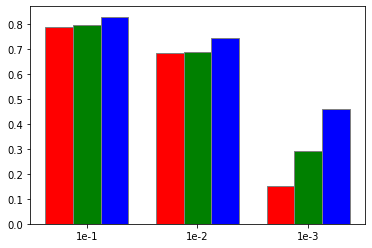

In [ ]:
barWidth = 0.25
br1 = np.arange(len(model_acc[2]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
x = np.array(["1e-1", "1e-2", "1e-3"])

plt.bar(br1 ,model_acc[0], color ='r', width = barWidth,
        edgecolor ='grey', label ='IT')
plt.bar(br2,model_acc[1], color ='g', width = barWidth,
        edgecolor ='grey', label ='ECE')
plt.bar(br3,model_acc[2], color ='b', width = barWidth,
        edgecolor ='grey', label ='CSE')
plt.xticks([r + barWidth for r in range(len(model_acc[2]))],
        ["1e-1", "1e-2", "1e-3"])
plt.legend()
plt.show()

100%|██████████| 3000/3000 [02:45<00:00, 18.10it/s]


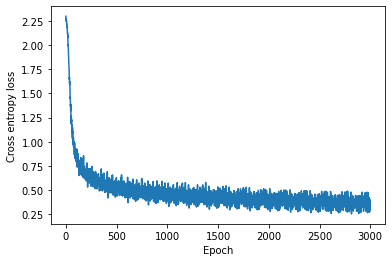

100%|██████████| 3000/3000 [05:36<00:00,  8.91it/s]


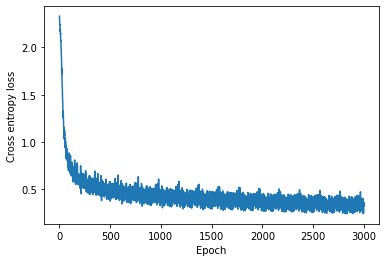

100%|██████████| 3000/3000 [10:43<00:00,  4.66it/s]


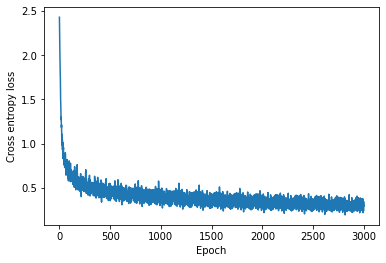

100%|██████████| 3000/3000 [20:47<00:00,  2.40it/s]


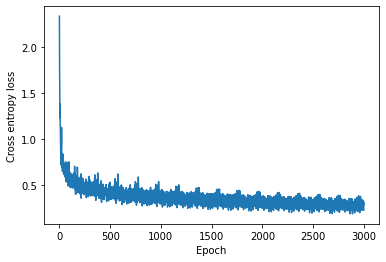

<function matplotlib.pyplot.show(*args, **kw)>

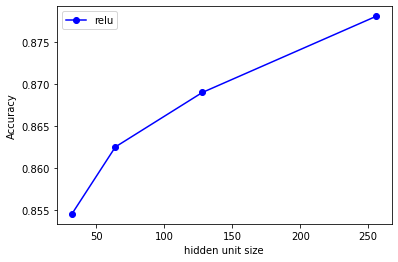

In [ ]:
hidden = [32,64,128,256]
acc = []

for hidden_size in hidden:
  model = MLP("Relu",2,[hidden_size,hidden_size],1e-1)
  model.fit(train_images, train_labels, GRADIENT_STEPS)
  acc.append(sum(model.predict(test_images)== test_labels)/len(test_labels))

plt.plot(hidden, acc, marker='o', color='blue', label='relu')
plt.xlabel("hidden unit size")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig('task3.png',dpi=300,bbox_inches='tight')
plt.show

In [ ]:
def evaluate(y_pred_temp,y_temp):
    accuracy = sum(y_pred_temp.argmax(axis=1) == y_temp)
    accuracy = accuracy / y_temp.shape[0]
    return accuracy

In [ ]:
knn = KNeighborsClassifier()
fit = knn.fit(train_images, train_labels)
y_test_prob = fit.predict_proba(test_images)

test_accuracy = evaluate(y_test_prob, test_labels)
print("KNN test:",test_accuracy)

DT = DecisionTreeClassifier(random_state=0)
DT.fit(train_images, train_labels)
y_test_prob = DT.predict(test_images)
test_accuracy = np.sum(y_test_prob == test_labels)/test_labels.shape[0]
print("DT test:",test_accuracy)


KNN test: 0.8554
DT test: 0.7901


# Task 3


## CNN

###import data

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalizing and reshaping the data**
#First, we normalize the image pixel values from [0, 255] to [-0.5, 0.5].
#Second, we reshape the images from (28, 28) to (28, 28, 1) to add the third dimension required by Keras

# Normalize the images
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (60000, 28, 28, 1)
print(test_images.shape)  # (10000, 28, 28, 1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print(train_labels.shape) # (60000, 10)
print(test_labels.shape)  # (10000, 10)


(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


In [ ]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = 10
batch_size  = 64
input_shape = (train_images.shape[1:]) # (28, 28, 1)
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down.
                      # When padding="same" and strides=1, the output has the same size as the input
model = Sequential()
model.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
model.add(MaxPooling2D(pool_size=pool_size)) # Keras automatically infers the shapes of inputs of later layers

model.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
model.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) # output layer

# Different syntax, different padding
model_2 = Sequential([
  Conv2D(filters = 4 * num_filters, kernel_size = filter_size, input_shape=(28, 28, 1), padding='same', activation='relu'),
  MaxPooling2D(pool_size=pool_size),
  Conv2D(8 * num_filters, kernel_size=(filter_size, filter_size), activation='relu'),
  MaxPooling2D(pool_size=(pool_size, pool_size)),
  Dropout(0.25),
  Flatten(),
  Dense(num_classes, activation='softmax'),
])

In [ ]:
model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
epochs = 100

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.
# Fitting the model
history = model.fit(
  train_images,
  train_labels,
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(test_images, test_labels), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings
)

Epoch 1/100
938/938 [==============================] - ETA: 0s - loss: 0.4862 - accuracy: 0.8196
Epoch 1: val_loss improved from inf to 0.36878, saving model to mnist_best_model.hdf5
938/938 [==============================] - 35s 37ms/step - loss: 0.4862 - accuracy: 0.8196 - val_loss: 0.3688 - val_accuracy: 0.8655
Epoch 2/100
937/938 [============================>.] - ETA: 0s - loss: 0.3183 - accuracy: 0.8831
Epoch 2: val_loss improved from 0.36878 to 0.31048, saving model to mnist_best_model.hdf5
938/938 [==============================] - 35s 37ms/step - loss: 0.3182 - accuracy: 0.8831 - val_loss: 0.3105 - val_accuracy: 0.8855
Epoch 3/100
938/938 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.9002
Epoch 3: val_loss improved from 0.31048 to 0.28836, saving model to mnist_best_model.hdf5
938/938 [==============================] - 35s 37ms/step - loss: 0.2714 - accuracy: 0.9002 - val_loss: 0.2884 - val_accuracy: 0.8963
Epoch 4/100
937/938 [=======================

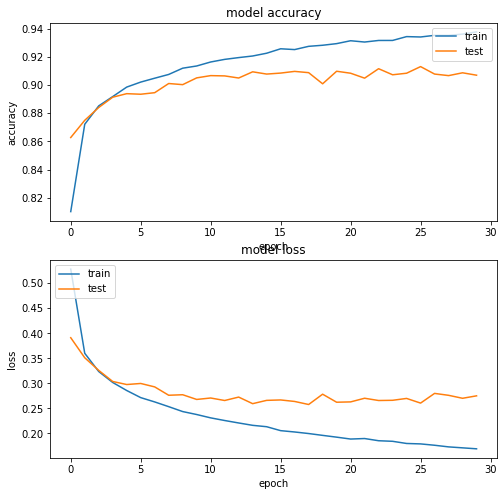

In [ ]:
# plot training history
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###confusion matrix

In [ ]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1

    return error, confusions

313/313 [==============================] - 2s 6ms/step
Test error: 9.3%


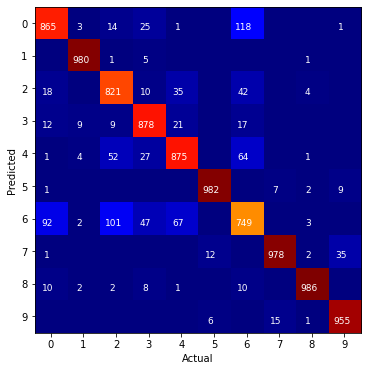

In [ ]:
test_predictions          = np.argmax(model.predict(test_images),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(test_labels,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

### alexnet

In [ ]:
# Load Fashion MNIST dataset
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)
CLASS_DESC = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = 10

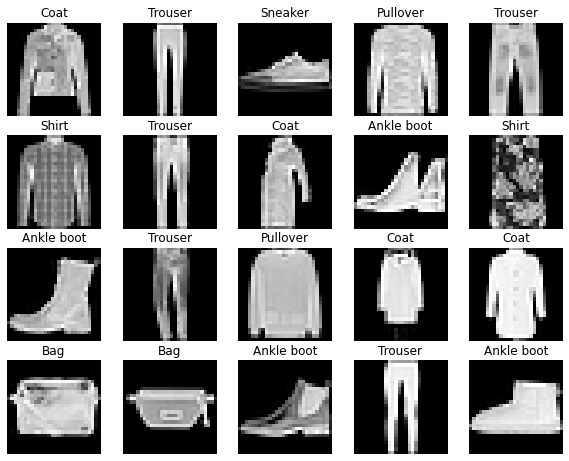

In [ ]:
# Visualize the dataset
plt.figure(figsize=(10,10))
sample_img_idx = np.random.randint(0, x_train.shape[0]+1, 20)
for i, j in enumerate(sample_img_idx):
    image, label = x_train[j], y_train[j]
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image, cmap=pyplot.get_cmap('gray'))
    plt.title(CLASS_DESC[label])
    plt.axis('off')

In [ ]:
# Pre-process data
train_labels = to_categorical(y_train, num_classes)
test_labels  = to_categorical(y_test, num_classes)

train_images = (x_train / 255)
test_images = (x_test / 255)

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

assert train_images.shape == (60000, 28, 28, 1)
assert test_images.shape == (10000, 28, 28, 1)
assert train_labels.shape == (60000, 10)
assert test_labels.shape == (10000, 10)

# New Section

100%|██████████| 2800/2800 [00:57<00:00, 48.94it/s]


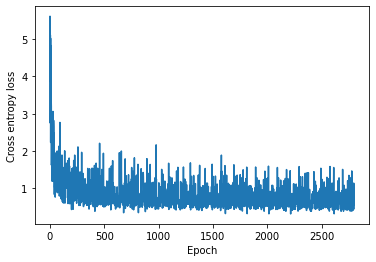

100%|██████████| 3000/3000 [00:59<00:00, 50.01it/s]


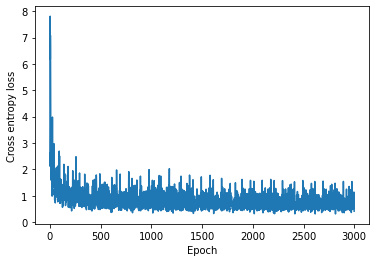

100%|██████████| 3200/3200 [01:03<00:00, 50.04it/s]


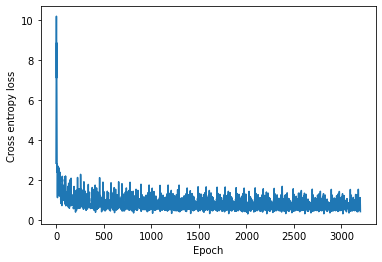

100%|██████████| 3400/3400 [01:09<00:00, 49.09it/s]


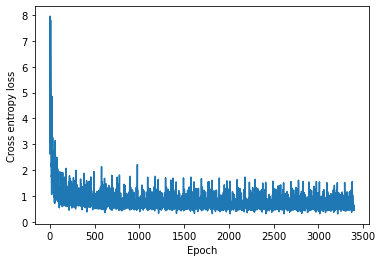

100%|██████████| 3600/3600 [01:13<00:00, 48.74it/s]


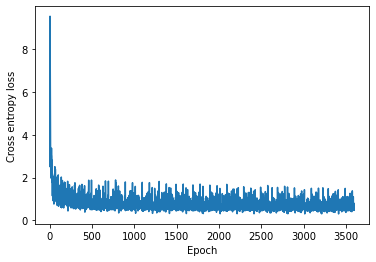

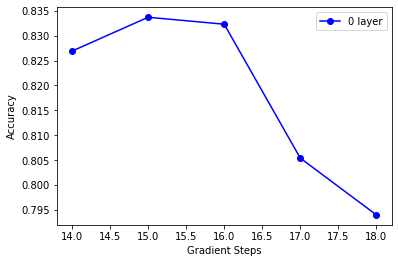

In [ ]:
epoch = [14,15, 16,17, 18]

test_acc = []
HIDDEN_SIZE = 128
acc = []
for it in epoch:
  mlp = MLP("Relu",0,[],1)
  mlp.fit(train_images, train_labels, it*200)
  acc.append(sum(mlp.predict(test_images)== test_labels)/len(test_labels))
test_acc.append(acc)

plt.plot(epoch, test_acc[0], marker='o', color='blue', label='0 layer')
plt.xlabel("Gradient Steps")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig('task3.png',dpi=300,bbox_inches='tight')
plt.show()

# acc = []

# for it in epoch:
#   mlp1 = MLP("Relu",1,[HIDDEN_SIZE],5e-1)
#   mlp1.fit(train_images, train_labels, it*200)
#   acc.append(sum(mlp1.predict(test_images)== test_labels)/len(test_labels))
# test_acc.append(acc)

# plt.plot(epoch, test_acc[1], marker='o', color='blue', label='0 layer')
# plt.xlabel("Gradient Steps")
# plt.ylabel("Accuracy")
# plt.legend()
# # plt.savefig('task3.png',dpi=300,bbox_inches='tight')
# plt.show()

# acc = []

# for it in epoch:
#   mlp2 = MLP("Relu",2,[HIDDEN_SIZE,HIDDEN_SIZE],5e-1)
#   mlp2.fit(train_images, train_labels, it*200)
#   acc.append(sum(mlp2.predict(test_images)== test_labels)/len(test_labels))

# test_acc.append(acc)


# plt.plot(epoch, test_acc[2], marker='o', color='green', label='2 layer')

# plt.xlabel("Gradient Steps")
# plt.ylabel("Accuracy")
# plt.legend()
# # plt.savefig('task3.png',dpi=300,bbox_inches='tight')
# plt.show()


In [ ]:
tanh_acc = []
for it in epoch:
  mlp_tanh = MLP("Tanh",2,[HIDDEN_SIZE,HIDDEN_SIZE],1e-1)
  mlp_tanh.fit(train_images, train_labels, it*200)
  tanh_acc.append(sum(mlp_tanh.predict(test_images)== test_labels)/len(test_labels))

plt.plot(epoch, tanh_acc, marker='o', color='blue', label='tanh')


plt.xlabel("Gradient Steps")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig('task3.png',dpi=300,bbox_inches='tight')
plt.show()

leaky_acc = []
for it in epoch:
  mlp_leaky = MLP("Leaky",2,[HIDDEN_SIZE,HIDDEN_SIZE],1e-1)
  mlp_leaky.fit(train_images, train_labels, it*200)
  leaky_acc.append(sum(mlp_leaky.predict(test_images)== test_labels)/len(test_labels))

plt.plot(epoch, leaky_acc, marker='o', color='red', label='leaky')

plt.xlabel("Gradient Steps")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig('task3.png',dpi=300,bbox_inches='tight')
plt.show()

l2_acc = []
for it in epoch:
  mlp_l2 = MLP("Relu",2,[HIDDEN_SIZE,HIDDEN_SIZE],1e-1,True)
  mlp_l2.fit(train_images, train_labels, it*200)
  l2_acc.append(sum(mlp_l2.predict(test_images)== test_labels)/len(test_labels))

plt.plot(epoch, l2_acc, marker='o', color='green', label='l2')

plt.xlabel("Gradient Steps")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig('task3.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalizing and reshaping the data**
#First, we normalize the image pixel values from [0, 255] to [-0.5, 0.5].
#Second, we reshape the images from (28, 28) to (28, 28, 1) to add the third dimension required by Keras

# Normalize the images
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (60000, 28, 28, 1)
print(test_images.shape)  # (10000, 28, 28, 1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print(train_labels.shape) # (60000, 10)
print(test_labels.shape)  # (10000, 10)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


In [ ]:
epoch = [15]

for e in epoch:
  num_filters = 8
  filter_size = 3
  pool_size   = 2
  num_classes = 10
  batch_size  = 64
  input_shape = (train_images.shape[1:]) # (28, 28, 1)
  strides     = 1
  padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down.
                        # When padding="same" and strides=1, the output has the same size as the input
  model = Sequential()
  model.add(Conv2D(filters = 4 * num_filters,
                  kernel_size = filter_size,
                  strides     = strides,
                  input_shape = input_shape,
                  padding     = padding,
                  activation  = 'relu')) # Sequential model needs the input shape
  model.add(MaxPooling2D(pool_size=pool_size)) # Keras automatically infers the shapes of inputs of later layers

  model.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
  model.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax')) # output layer

  model.compile(
    'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
    loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
    metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
  )

  # Saving the model during training to be used later
  checkpoint = ModelCheckpoint("mnist_best_model.hdf5",  # saving the best model
                              monitor='val_loss', verbose=1,
                              save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
                              save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                              mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                              save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.
  # Fitting the model
  history = model.fit(
    train_images,
    train_labels,
    epochs=e,                # number of training epochs
    batch_size=batch_size,
    verbose = 1,
    validation_data=(test_images, test_labels), # validation data
    callbacks=[checkpoint]      # callback to save the model during trainings
  )


Epoch 1/15
937/938 [============================>.] - ETA: 0s - loss: 0.4857 - accuracy: 0.8220
Epoch 1: val_loss improved from inf to 0.34482, saving model to mnist_best_model.hdf5
938/938 [==============================] - 13s 13ms/step - loss: 0.4856 - accuracy: 0.8221 - val_loss: 0.3448 - val_accuracy: 0.8746
Epoch 2/15
937/938 [============================>.] - ETA: 0s - loss: 0.3135 - accuracy: 0.8844
Epoch 2: val_loss improved from 0.34482 to 0.29972, saving model to mnist_best_model.hdf5
938/938 [==============================] - 12s 13ms/step - loss: 0.3135 - accuracy: 0.8844 - val_loss: 0.2997 - val_accuracy: 0.8870
Epoch 3/15
936/938 [============================>.] - ETA: 0s - loss: 0.2741 - accuracy: 0.8991
Epoch 3: val_loss improved from 0.29972 to 0.28150, saving model to mnist_best_model.hdf5
938/938 [==============================] - 12s 13ms/step - loss: 0.2741 - accuracy: 0.8991 - val_loss: 0.2815 - val_accuracy: 0.8953
Epoch 4/15
936/938 [===========================